In [1]:
from torch_geometric.data import DataLoader
import torch.distributions as D
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors, rdMolTransforms
from rdkit import rdBase
from datetime import datetime
import glob
import os

import deepdock
from deepdock.utils.distributions import *
from deepdock.utils.data import *
from deepdock.models import *

# set the random seeds for reproducibility
np.random.seed(123)
torch.cuda.manual_seed_all(123)
torch.manual_seed(123)

%matplotlib inline

RDKit WARNING: [08:35:52] Enabling RDKit 2019.09.1 jupyter extensions


In [2]:
%%time
db_complex = PDBbind_complex_dataset(data_path=deepdock.__path__[0]+'/../data/dataset_deepdock_pdbbind_v2019_16K.tar', 
                                     min_target_nodes=50, max_ligand_nodes=None)
db_complex = db_complex.shuffle()
db_complex_train = db_complex[:15000]
db_complex_test = db_complex[15000:]
pdbIDs_test = [db_complex_test.data[i][3] for i in db_complex_test.indices()]
pdbIDs_train = [db_complex_train.data[i][3] for i in db_complex_train.indices()]
print('Complexes in training set:', len(db_complex_train))
print('Complexes in test set:', len(db_complex_test))


Complexes in training set: 15000
Complexes in test set: 1367
CPU times: user 3.65 s, sys: 9 s, total: 12.7 s
Wall time: 12.7 s


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ligand_model = LigandNet(28, residual_layers=10, dropout_rate=0.10)
target_model = TargetNet(4, residual_layers=10, dropout_rate=0.10)
model = DeepDock(ligand_model, target_model, hidden_dim=64, n_gaussians=10, dropout_rate=0.10, dist_threhold=7.).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

epochs = 150
batch_size = 16
save_each=25
aux_weight = 0.001
losses = []
loader_train = DataLoader(db_complex_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(db_complex_test, batch_size=batch_size, shuffle=False)

In [4]:
%%time
now = datetime.now()
print(now.strftime("Start date: %d/%m/%Y at %H:%M:%S"))

def train():
    model.train()

    total_loss = 0
    mdn_loss = 0
    atom_loss = 0
    bond_loss = 0
    for data in loader_train:
        optimizer.zero_grad()
        ligand, target, activity, pdbid = data
        ligand, target, activity = ligand.to(device), target.to(device), activity[0].unsqueeze(1).to(device)
        atom_labels = torch.argmax(ligand.x, dim=1, keepdim=False)
        bond_labels = torch.argmax(ligand.edge_attr, dim=1, keepdim=False)
        
        pi, sigma, mu, dist, atom_types, bond_types, batch = model(ligand, target)
        
        mdn = mdn_loss_fn(pi, sigma, mu, dist)
        mdn = mdn[torch.where(dist <= model.dist_threhold)[0]]
        mdn = mdn.mean()
        atom = F.cross_entropy(atom_types, atom_labels)
        bond = F.cross_entropy(bond_types, bond_labels)
        loss = mdn + (atom * aux_weight) + (bond * aux_weight)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * (ligand.batch.max().item() + 1)
        mdn_loss += mdn.item() * (ligand.batch.max().item() + 1)
        atom_loss += atom.item() * (ligand.batch.max().item() + 1)
        bond_loss += bond.item() * (ligand.batch.max().item() + 1)
        
        #print('Step, Total Loss: {:.3f}, MDN: {:.3f}'.format(total_loss, mdn_loss))
        if np.isinf(mdn_loss) or np.isnan(mdn_loss): break
        
    return total_loss / len(loader_train.dataset), mdn_loss / len(loader_train.dataset), atom_loss / len(loader_train.dataset), bond_loss / len(loader_train.dataset)


@torch.no_grad()
def test(dataset):
    model.eval()

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    total_loss = 0
    mdn_loss = 0
    atom_loss = 0
    bond_loss = 0
    for data in loader:
        ligand, target, activity, pdbid = data
        ligand, target, activity = ligand.to(device), target.to(device), activity[0].unsqueeze(1).to(device)
        atom_labels = torch.argmax(ligand.x, dim=1, keepdim=False)
        bond_labels = torch.argmax(ligand.edge_attr, dim=1, keepdim=False)
        
        pi, sigma, mu, dist, atom_types, bond_types, batch = model(ligand, target)
            
        mdn = mdn_loss_fn(pi, sigma, mu, dist)
        mdn = mdn[torch.where(dist <= model.dist_threhold)[0]]
        mdn = mdn.mean()
        atom = F.cross_entropy(atom_types, atom_labels)
        bond = F.cross_entropy(bond_types, bond_labels)
        loss = mdn + (atom * aux_weight) + (bond * aux_weight)
        
        total_loss += loss.item() * (ligand.batch.max().item() + 1)
        mdn_loss += mdn.item() * (ligand.batch.max().item() + 1)
        atom_loss += atom.item() * (ligand.batch.max().item() + 1)
        bond_loss += bond.item() * (ligand.batch.max().item() + 1)

    return total_loss / len(loader.dataset), mdn_loss / len(loader.dataset), atom_loss / len(loader.dataset), bond_loss / len(loader.dataset)

prev_test_total_loss = 1000
for epoch in range(1, epochs + 1):
    total_loss, mdn_loss, atom_loss, bond_loss = train()
    if np.isinf(mdn_loss) or np.isnan(mdn_loss): 
        print('Inf ERROR')
        break
    test_total_loss, test_mdn_loss, test_atom_loss, test_bond_loss = test(db_complex_test)
    losses.append([total_loss, mdn_loss, atom_loss, bond_loss, test_total_loss, test_mdn_loss, test_atom_loss, test_bond_loss])
    
    if test_mdn_loss <= prev_test_total_loss:
        prev_test_total_loss = test_total_loss
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'rng_state': torch.get_rng_state(), 'total_loss': total_loss,  
                    'mdn_loss': mdn_loss, 'atom_loss': atom_loss, 'bond_loss': bond_loss, 'pdbIDs_train':pdbIDs_train, 'pdbIDs_test':pdbIDs_test}, 'DeepDock_pdbbindv2019_13K_minTestLoss.chk')
    l = pd.DataFrame(losses, columns= ['total_loss', 'mdn_loss', 'atom_loss', 'bond_loss', 'test_total_loss', 'test_mdn_loss', 'test_atom_loss', 'test_bond_loss'])
    l.to_csv('DeepDock_pdbbindv2019_13K_loss.csv')
      
    print('Epoch: {:03d}, Total Loss: {:.3f}, MDN: {:.3f}, Atom: {:.3f}, Bond: {:.3f}'.format(epoch, total_loss, mdn_loss, atom_loss, bond_loss))
    
    if epoch % save_each == 0:
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'rng_state': torch.get_rng_state(), 'total_loss': total_loss,  
                    'mdn_loss': mdn_loss, 'atom_loss': atom_loss, 'bond_loss': bond_loss, 'pdbIDs_train':pdbIDs_train, 'pdbIDs_test':pdbIDs_test}, 'DeepDock_pdbbindv2019_13K_epoch_%.3i.chk'%(epoch))
        l = pd.DataFrame(losses, columns= ['total_loss', 'mdn_loss', 'atom_loss', 'bond_loss', 'test_total_loss', 'test_mdn_loss', 'test_atom_loss', 'test_bond_loss'])
        l.to_csv('DeepDock_pdbbindv2019_13K_loss.csv')
    
torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'rng_state': torch.get_rng_state(), 'total_loss': total_loss,  
            'mdn_loss': mdn_loss, 'atom_loss': atom_loss, 'bond_loss': bond_loss, 'pdbIDs_train':pdbIDs_train, 'pdbIDs_test':pdbIDs_test}, 'DeepDock_pdbbindv2019_13K_epoch_%.3i.chk'%(epoch))
l = pd.DataFrame(losses, columns= ['total_loss', 'mdn_loss', 'atom_loss', 'bond_loss', 'test_total_loss', 'test_mdn_loss', 'test_atom_loss', 'test_bond_loss'])
l.to_csv('DeepDock_pdbbindv2019_13K_loss.csv')

Start date: 14/11/2020 at 08:37:32
Epoch: 001, Total Loss: 1.692, MDN: 1.692, Atom: 0.247, Bond: 0.120
Epoch: 002, Total Loss: 1.610, MDN: 1.610, Atom: 0.032, Bond: 0.030
Epoch: 003, Total Loss: 1.602, MDN: 1.602, Atom: 0.015, Bond: 0.021
Epoch: 004, Total Loss: 1.593, MDN: 1.593, Atom: 0.009, Bond: 0.017
Epoch: 005, Total Loss: 1.583, MDN: 1.583, Atom: 0.008, Bond: 0.014
Epoch: 006, Total Loss: 1.573, MDN: 1.573, Atom: 0.006, Bond: 0.012
Epoch: 007, Total Loss: 1.561, MDN: 1.561, Atom: 0.006, Bond: 0.011
Epoch: 008, Total Loss: 1.556, MDN: 1.556, Atom: 0.005, Bond: 0.011
Epoch: 009, Total Loss: 1.547, MDN: 1.547, Atom: 0.004, Bond: 0.011
Epoch: 010, Total Loss: 1.538, MDN: 1.538, Atom: 0.004, Bond: 0.010
Epoch: 011, Total Loss: 1.530, MDN: 1.530, Atom: 0.004, Bond: 0.010
Epoch: 012, Total Loss: 1.524, MDN: 1.524, Atom: 0.004, Bond: 0.009
Epoch: 013, Total Loss: 1.518, MDN: 1.518, Atom: 0.004, Bond: 0.009
Epoch: 014, Total Loss: 1.513, MDN: 1.513, Atom: 0.004, Bond: 0.009
Epoch: 015, T

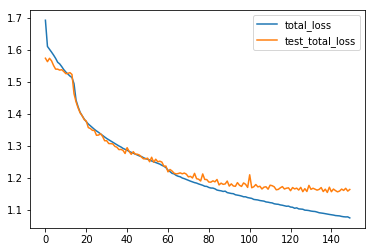

In [5]:
#l = pd.read_csv('AE_ResMeta_Dropout10_DeepDock_pdbbindv2019_14K_loss.csv')
l[['total_loss', 'test_total_loss']].plot()